In [1]:
import torch
import torch.nn as nn
import numpy as np
import h5py
import os

snr_encoding = ['clean', '_6', '00', '06', '12', '18', '24']

class DB10s(torch.utils.data.Dataset):
    def __init__(self, mode):
        self.h5_list = []
        for root, dirs, files in os.walk('../../data_10s'):
            for f in files:
                path = os.path.join(root, f)
                with h5py.File(path, 'r') as h5:
                    if h5['MLII'][:].size != 3600:
                        continue
                abs_fname = os.path.join(root, f)
                if mode == 'train':
                    if '118' in abs_fname and abs_fname.split('/')[-2] != '118':
                        self.h5_list.append(abs_fname)
                elif mode == 'val':
                    if '119' in abs_fname and abs_fname.split('/')[-2] != '119':
                        self.h5_list.append(abs_fname)
        
    def __getitem__(self, i):
        fname = self.h5_list[i]
#         print(fname)
        with h5py.File(fname, 'r') as f:
            index = f['index'][()]
            MLII = torch.tensor(f['MLII'][:])
            SNR = torch.tensor(snr_encoding.index(f['SNR'][()]))
        
        clean_fname = self.get_clean_fname(i)
#         print(clean_fname)
        
        with h5py.File(clean_fname, 'r') as f:
            clean_index = f['index'][()]
            clean_MLII = torch.tensor(f['MLII'][:])
            clean_SNR = torch.tensor(snr_encoding.index(f['SNR'][()]))
        assert clean_index==index, 'clean image is not matched'
        assert clean_SNR.item() == 0, 'clean image is not clean(SNR)'
        return {
            'index': index,
            'MLII': MLII.float(),
            'clean': clean_MLII.float(),
            'SNR': SNR
        }
    def __len__(self):
        return len(self.h5_list)
    
    def get_clean_fname(self, index):
        fname = self.h5_list[index]
        clean_fname = fname.split('/')[:-1]
        clean_fname[-1] = clean_fname[-1][:3]
        clean_fname = '/'.join(clean_fname)
        clean_fname += '/'+fname.split('/')[-1]
        return clean_fname
        
dataset = DB10s('train')

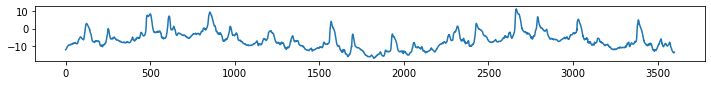

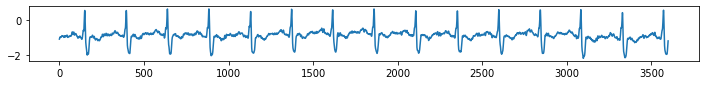

SNR: 1
Length: 1087


In [8]:
import matplotlib.pyplot as plt
index, MLII, clean, SNR = dataset[41].values()

plt.figure(figsize=(12, 1))
plt.plot(range(len(MLII)), MLII)
plt.show()
plt.figure(figsize=(12, 1))
plt.plot(range(len(clean)), clean)
plt.show()
print('SNR:', SNR.item())
print('Length:', len(dataset))